In [1]:
%matplotlib inline

# The script to evaluate the result from deep neural networks

This module can use for processing evaluation. You need modify the index of test label you want and model_filename to locate you store model. And you can modify output directory you want and input directory you have.

-----------------------Begining data input-------------------------
Successful import datasets from ./datasets/final_dataset
---------------------Begining eliminate noise ---------------------
The network summary for audio_u_net_dnn
    input: [80000, 1]
    downsample layer: [39998, 8]
    downsample layer: [19998, 16]
    downsample layer: [9998, 32]
    downsample layer: [4998, 64]
    downsample layer: [2498, 128]
    downsample layer: [1248, 256]
    downsample layer: [623, 512]
    downsample layer: [311, 1024]
    bottleneck layer: [154, 2048]
    upsample layer: [304, 2048]
    upsample layer: [604, 1024]
    upsample layer: [1204, 512]
    upsample layer: [2404, 256]
    upsample layer: [4804, 128]
    upsample layer: [9604, 64]
    upsample layer: [19204, 32]
    upsample layer: [38404, 16]
    restack layer: [40002, 15]
    final convolution layer: [40000, 2]
    output: [80000, 1]
--------------------Finished model building--------------------
INFO:tensorflow:Restoring para

/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


The plot will be saved in file: ./output/plotting
---------------------Finished plot the waveform-------------------------


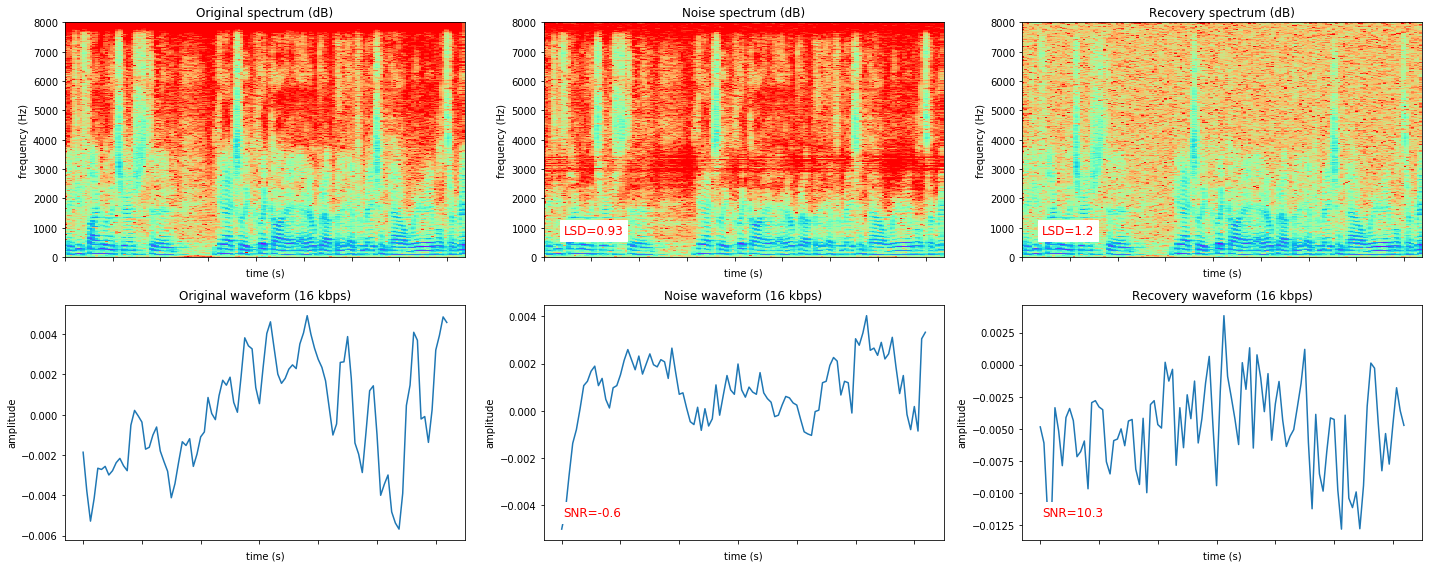

In [2]:
# -*- coding: utf-8 -*-
""" The script to evaluate the result from deep neural networks

This module can use for processing evaluation. You need modify the index of test 
label you want and model_filename to locate you store model. And you can modify 
output directory you want and input directory you have.

################################################################################
# Author: Weikun Han <weikunhan@gmail.com>
# Crate Date: 03/10/2018        
# Update:
# Reference: https://github.com/jhetherly/EnglishSpeechUpsampler
################################################################################
"""

import numpy as np
import os
import librosa
import tensorflow as tf
from converter_generator import get_original_noise_pairs
from converter_generator import bitrates_and_waveforms
from model import audio_u_net_dnn
from plotting import plot_figures
from plotting import read_audio_spectrum

# Please modify input path  to locate you file
DATASETS_ROOT_DIR = './datasets'
FILE_NAME_LISTS_DIR = os.path.join(DATASETS_ROOT_DIR, 'final_dataset')
MODEL_DIR = './output/model'
OUTPUT_WAV_DIR = './output/wav'
OUTPUT_PLOT_DIR = './output/plotting'
    
# Please modify setting for testing
test_number = 0
model_filename = os.path.join(MODEL_DIR, 'audio_u_net_dnn_final.ckpt')
fft_window_size = 4 * 512
    
# Check location to save datasets
if not os.path.exists(OUTPUT_WAV_DIR):
    os.makedirs(OUTPUT_WAV_DIR)
if not os.path.exists(OUTPUT_PLOT_DIR):
    os.makedirs(OUTPUT_PLOT_DIR)
    
print('-----------------------Begining data input-------------------------')

#############
# DATA IMPORT
#############

test_original_noise_pairs = get_original_noise_pairs(FILE_NAME_LISTS_DIR,
                                                         'test')

# Selet first original noise pair, return first is bit rate pair and second
# is the waveform pair
br_pair, wf_pair = bitrates_and_waveforms(
        test_original_noise_pairs[test_number])

# Get original bit rate and waveform
original_bitrate = br_pair[0]
original_waveform = wf_pair[0]
noise_bitrate = br_pair[1]
noise_waveform = wf_pair[1]

# reshape for mono waveforms
original_waveform = original_waveform.reshape((-1, 1))
noise_waveform = noise_waveform.reshape((-1, 1))
                        
print('Successful import datasets from {}'.format(FILE_NAME_LISTS_DIR))
print('---------------------Begining eliminate noise ---------------------')

##################
# MODEL DEFINITION
##################

train_flag, x, y_pred = audio_u_net_dnn(original_waveform.dtype,
                                            original_waveform.shape,
                                            tensorboard_output=False)

# placeholder for the truth label
y = tf.placeholder(original_waveform.dtype,
                       shape=x.get_shape(),
                       name='y')

###############
# LOSS FUNCTION
###############

with tf.name_scope('mse'):
    mse = tf.reduce_mean(tf.square(tf.subtract(y_pred, y)))
tf.summary.scalar('mse', mse)
 
#################
# ELIMINATE NOISE
#################
    
# Add ops to restore all the variables.
saver = tf.train.Saver()

with tf.Session() as sess:

    # restore model from checkpoint file
    saver.restore(sess, model_filename)
    
    # Get the recovery waveform
    recovery_waveform = y_pred.eval(
        feed_dict={train_flag: False,
                   x: noise_waveform.reshape(1, -1, 1)})
    
    print('----------------------Finished eliminate noise-----------------')

print('Difference between original and noise (first 20 elements)')
print(original_waveform.flatten()[:20] - noise_waveform.flatten()[:20])
print('Difference between original and recovery (first 20 elements)')
print(original_waveform.flatten()[:20] - recovery_waveform.flatten()[:20])

output_original_filename = os.path.join(
        OUTPUT_WAV_DIR, 'test_original_audio_{}.wav'.format(test_number))
librosa.output.write_wav(output_original_filename,
                         y=original_waveform.flatten(), 
                         sr=original_bitrate)
output_noise_filename = os.path.join(
        OUTPUT_WAV_DIR, 'test_noise_audio_{}.wav'.format(test_number))
librosa.output.write_wav(output_noise_filename,
                         y=noise_waveform.flatten(), 
                         sr=original_bitrate)
output_recovery_filename = os.path.join(
        OUTPUT_WAV_DIR, 'test_recovery_audio_{}.wav'.format(test_number))
librosa.output.write_wav(output_recovery_filename,
                         y=recovery_waveform.flatten(),
                         sr=original_bitrate)

print('The .wav file will be saved in file: {}'.format(OUTPUT_WAV_DIR))
print('---------------------Finished .wav file export-------------------------')

# Load the audio just generate in OUTPUT_WAV_DIR
original_waveform, original_bitrate = librosa.load(output_original_filename, 
                                                   sr=None)
noise_waveform, noise_bitrate = librosa.load(output_noise_filename, 
                                             sr=None)
recovery_waveform, recovery_bitrate = librosa.load(output_recovery_filename, 
                                                   sr=None)

# Get each audio spectrogram
original_spectrogram = read_audio_spectrum(original_waveform, fft_window_size)
noise_spectrogram = read_audio_spectrum(noise_waveform, fft_window_size)
recovery_spectrogram = read_audio_spectrum(recovery_waveform, fft_window_size)

# Plot all audio spectrogram
plot_filename = os.path.join(OUTPUT_PLOT_DIR, 'test_{}'.format(test_number))
plot_figures(original_spectrogram, 
             noise_spectrogram, 
             recovery_spectrogram,
             original_waveform, 
             noise_waveform, 
             recovery_waveform,
             original_bitrate, 
             noise_bitrate, 
             recovery_bitrate,
             plot_filename, 
             fft_window_size)

print('The plot will be saved in file: {}'.format(OUTPUT_PLOT_DIR))
print('---------------------Finished plot the waveform-------------------------')